# Data Exploration

Now that our NPZ data file is ready, let's use it and perform some data exploration.

And first of all, load the NPZ file and feed some variables we will need in this Notebook.

To do so, I will define a function that will open the NPZ file and returns the same structure I've used in the previous notebook, a Python dict with the following structure:

        dict={
            'CONSTANT_LABEL': CONSTANT_VALUE,
            [...],
            'train': {
                'data': np.array of image data,
                'features': np.array of images features,
                'filenames': np.array of image filenames,
            }
            'test': {
                'data': np.array of image data,
                'features': np.array of images features,
                'filenames': np.array of image filenames,
            }
            'valid': {
                'data': np.array of image data,
                'features': np.array of images features,
                'filenames': np.array of image filenames,
            },
            'trainX': {
                'data': np.array of image data,
                'features': np.array of images features,
                'filenames': np.array of image filenames,
            },
        }

> Note: *trainX* dataset is a concatenation of the *train* and *valid* dataset

Hey, wait a minute ? Why did I wrote this loading process as a function ?

Well, as I will have to run that function within most of the project Notebooks, I will copy the code into a file *mylib.py* which I'll import using the *%run* keyword.

Furthermore, I will enrich that *mylib.py* with other usefull function I might need along that project.

## NPZ data loading function

Here is the code of the *loadNpz()* function that will be copied into *mylib.py* file

    import numpy as np
    import os

    def loadNpz(filename=os.path.join('data','data.npz')):
        """
        This function returns the content of the NPZ file passed as parameter.
        The NPZ file passed must been build according to the first Notebook process of this project.
        The value returned complies to the structure described above.
        """
    
        # initialize returned variable
        data_dict=dict()

        # Load the NPZ file
        with np.load(filename) as npz_file:

            # Load constant
            data_dict={key: value for key, value in zip(npz_file['constant_label'], npz_file['constant_value'])}    

            for name in data_dict['DATASET_NAME']:
                print("Loading '{}' set".format(name))
                data_dict[name]=dict()

                for data_type in ['data', 'features', 'filenames']:
                    print("  loading ", data_type)
                    data_dict[name][data_type]=npz_file['{}_{}'.format(name, data_type)]
                    print('     shape: {} - dtype: {}'.format(data_dict[name][data_type].shape, data_dict[name][data_type].dtype))

                print("\n")
            return data_dict

> Note: The code above might not be the latest one. Please check the content of *mylib.py* to get the most up to date algorythm

To use that code and load data in our Notebook, simply use the *%run* key and call the *loadNpz()* function:

In [1]:
# Run content of mylib.py file
%run mylib.py

# Load data from NPZ file
data=loadNpz()

Loading 'train' set
  loading  data
     shape: (281, 299, 299, 3) - dtype: float64
  loading  features
     shape: (281, 2048) - dtype: float64
  loading  filenames
     shape: (281,) - dtype: <U46
  loading  labels
     shape: (281,) - dtype: int32


Loading 'test' set
  loading  data
     shape: (51, 299, 299, 3) - dtype: float64
  loading  features
     shape: (51, 2048) - dtype: float64
  loading  filenames
     shape: (51,) - dtype: <U50
  loading  labels
     shape: (51,) - dtype: int32


Loading 'valid' set
  loading  data
     shape: (139, 299, 299, 3) - dtype: float64
  loading  features
     shape: (139, 2048) - dtype: float64
  loading  filenames
     shape: (139,) - dtype: <U30
  loading  labels
     shape: (139,) - dtype: int32


building 'valid' set
  building  data
     shape: (420, 299, 299, 3) - dtype: float64
  building  features
     shape: (420, 2048) - dtype: float64
  building  filenames
     shape: (420,) - dtype: <U46
  building  labels
     shape: (420,) - dty

## Plot a few images from each category

I use random.randint() method to pickup 5 random images in all the dataset. I then use the trick described in the previous Notebook to display the images


5 random images from train dataset:


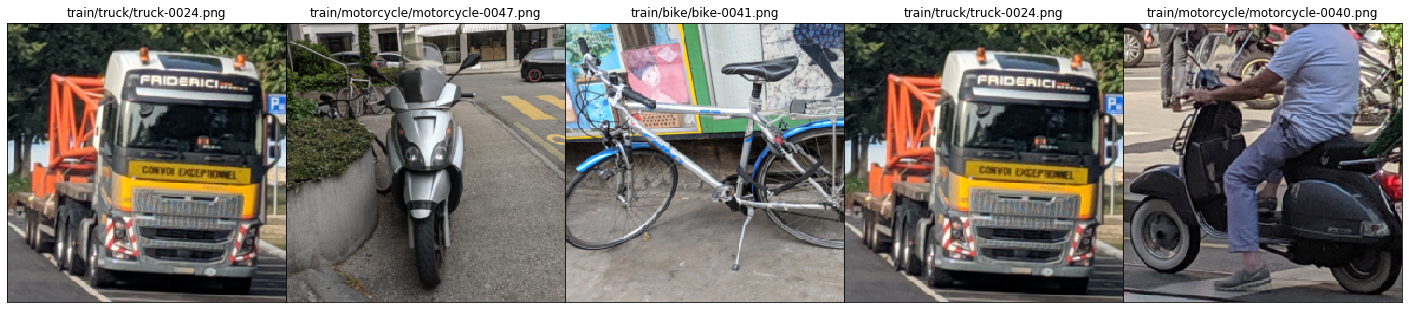


5 random images from test dataset:


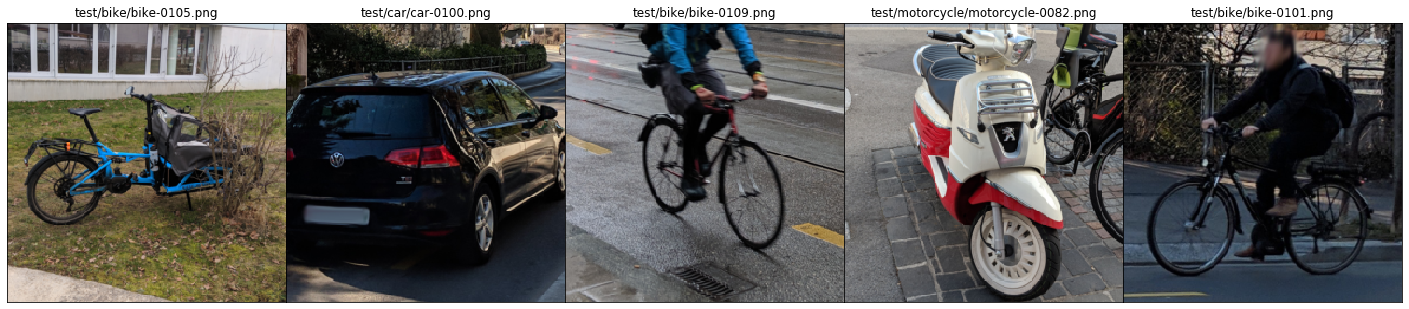


5 random images from valid dataset:


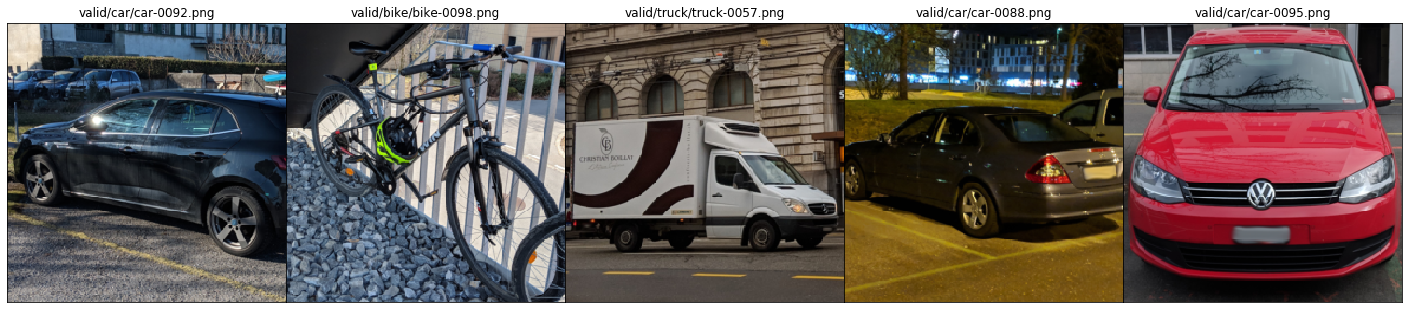

In [2]:
from random import randint


%matplotlib inline
import matplotlib.pyplot as plt


# Plot random images from each dataset
for name in data['DATASET_NAME']:
    print("\n5 random images from {} dataset:".format(name))
    
    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 10))

    # Remove gaps between suplots
    plt.subplots_adjust(wspace=0, hspace=0)

    for i, axis in enumerate(axes.flatten()):
        image_index=randint(0, len(data[name]['data'])-1)
        axis.imshow(np.array(data[name]['data'][image_index]*255, dtype=np.uint8))
        axis.get_xaxis().set_visible(False) # disable x-axis
        axis.get_yaxis().set_visible(False) # disable y-axis
        axis.set_title('{}/{}'.format(name, data[name]['filenames'][image_index]))
    
    plt.show()

## PCA exploration

In order to perform PCA exploration, I will work with the train high-level features.

I will first normalize them using a StandardScaler and then, fit a PCA using None as number of components. As we are seeking for the % of variance per number of components, using this strategy will permit us to identify the number of components needed to get a certain % of total variance contained in this number of components.

To seek this %, after fitting the PCA, I will use its *explained_variance_ratio_* to get a list of % of variance each feature covers. This array will be used at first to build a scree plot.


In [47]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Create X and y variable
X=data['train']['features']
y=data['train']['labels']

# X=data['train']['features']
pca=PCA(n_components=None)

pca.fit(X, y=None)

# Proportion of variance explained
pve = pca.explained_variance_ratio_

## Build a scree plot

Now that the *explained_variance_ratio_* is ready, we can draw a scree plot with it.

> Note: The following code as been grabbed from the courses

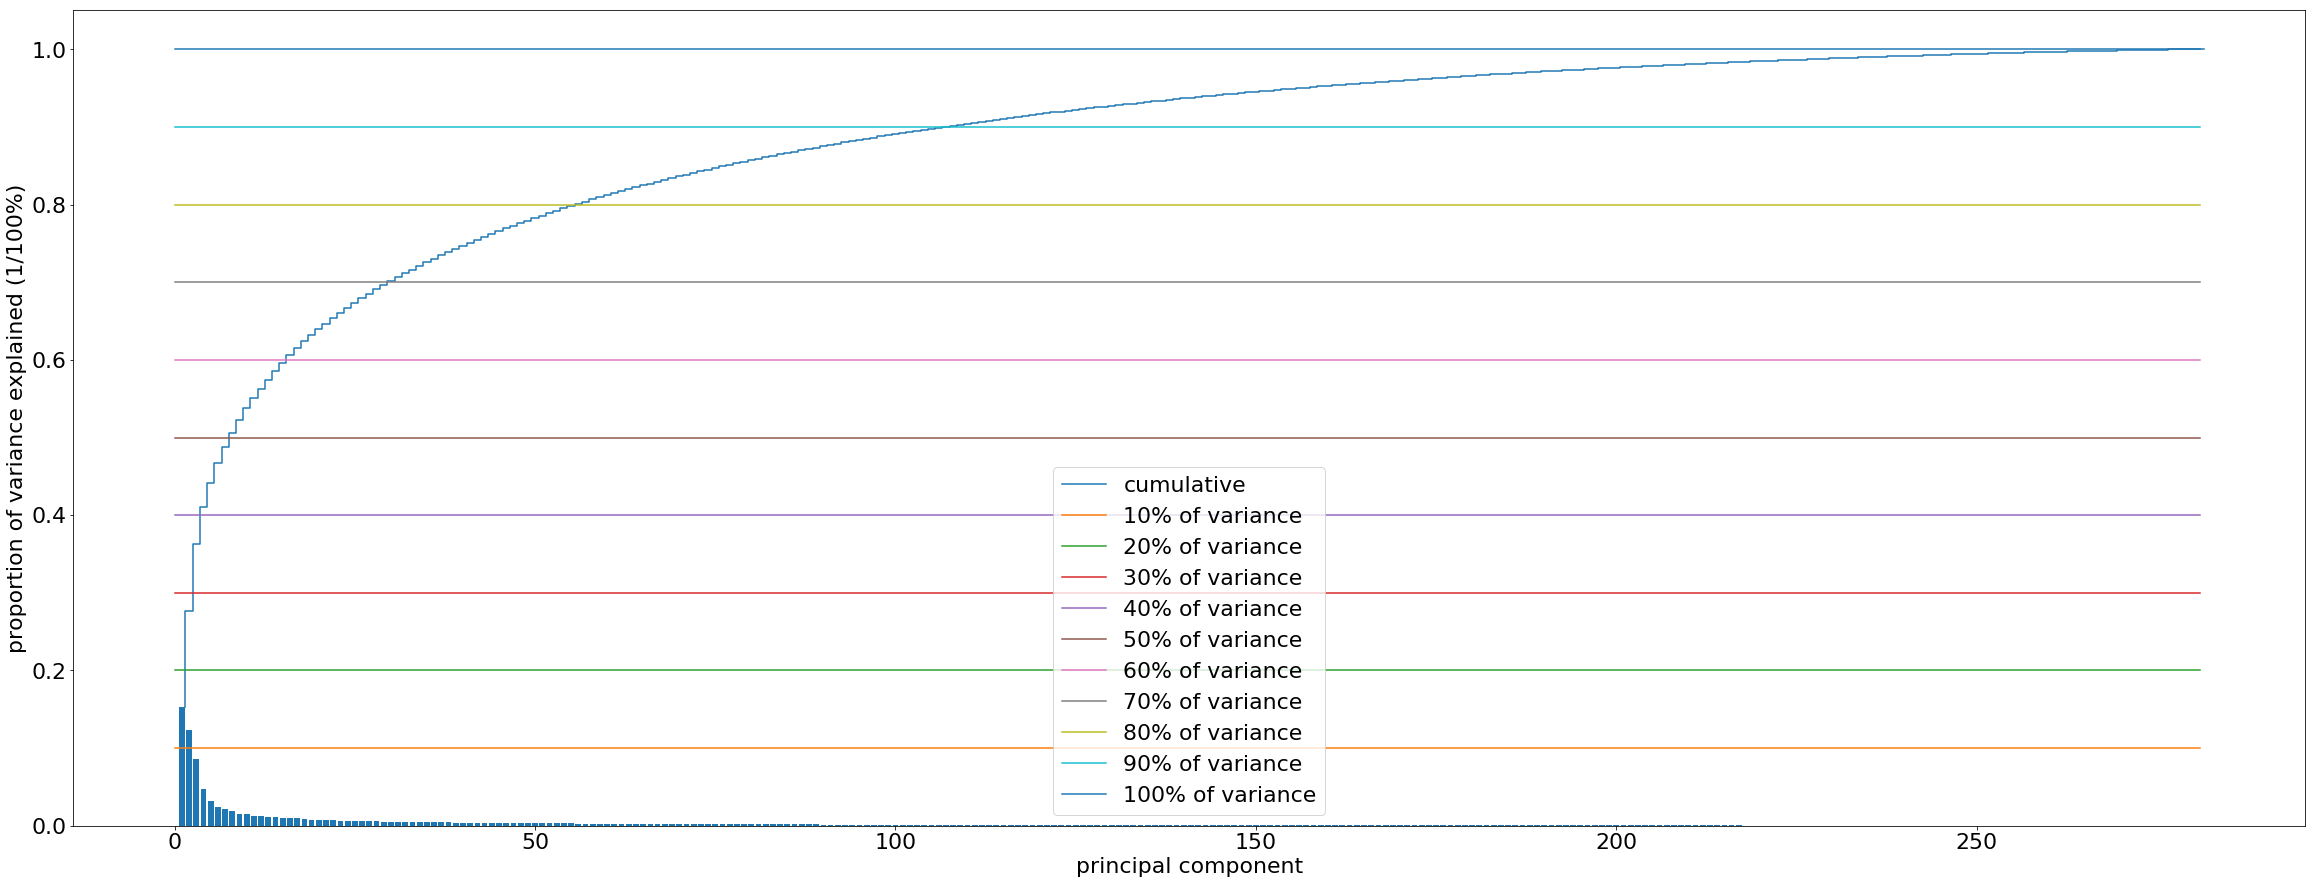

In [48]:
plt.figure(figsize=(40,15))
plt.rcParams.update({'font.size': 22})

# Create bar plot
xcor = np.arange(1, len(pve) + 1) # 1,2,..,n_components
plt.bar(xcor, pve)


# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5, # 1.5,2.5,..,n_components+0.5
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

for i in np.arange(0.1, 1.1, 0.1).tolist():
    plt.plot([0,len(X)], [i, i], label='{}% of variance'.format(int(i*100)))

plt.xlabel('principal component')
plt.ylabel('proportion of variance explained (1/100%)')
plt.legend()
plt.show()

## How many PCA components explain 10%, 20%, …, 90% and 100% of the variance?

In the previous graph, I've plotted horizontal lines correspondig to the 10%, 20%, ..., 90% and 100% of the variance. It's quite easy to answer to some of them how many components are needed to cover a certain % of variance:

* 10%: One component is enough
* 20*: Three compnents
* 30%: Four components
* 40%: Height components

Other values are difficult to read, appart if we draw a really high resolution graph.

Even if an higer resolution could work, counting the number of components that gets 80% of the variance will be very tricky. Let's choose another approach: Iterate over the *explained_variance_ratio_* array, sum its elements one by one, and check each time the sum reach the % we are looking for. The number of components we have in the sum are the number of components needed to cover the % of variance.


In [49]:
# sum of components
sum_total=0

# number of components in the sum
nb_components=0

# Percentage level we are looking for
percentage_level=np.arange(0.1, 1.2, 0.1).tolist()

# index of the percentage level
percentage_index=0

print("Number of PCA components that explain 10%, 20%, …, 90% and 100% of the variance")
print("Total number of components:", len(pve))

# for each entry in pve
for i in pve:
    # sum current entry to total
    sum_total+=i
    
    # Increment counter of components
    nb_components+=1
    
    # Did we reach our current percentage limit ?
    if sum_total>percentage_level[percentage_index]:
        # Print % and nb_components
        print('{:3.0f}% => {:3.0f} components'.format(percentage_level[percentage_index]*100, nb_components))
        
        # select the next percentage index
        percentage_index+=1


Number of PCA components that explain 10%, 20%, …, 90% and 100% of the variance
Total number of components: 281
 10% =>   1 components
 20% =>   2 components
 30% =>   3 components
 40% =>   4 components
 50% =>   8 components
 60% =>  16 components
 70% =>  30 components
 80% =>  56 components
 90% => 107 components
100% => 279 components


Surprisingly, the 100% of the variance is contained in all the component minus 1 (the last one). That sounds strange as the 100% of variance is obtain when considering all of the components, not all minus one.

So, where is the error ?

In fact, the last value of the pve array is a very, very small number (3.5044189467799334e-33), and I suppose that on the platform I use (Apple Silicon M1), the float precision is not sufficient and in the precedent algorithm, when I perform the test *sum_total>percentage_level[percentage_index]*, the rounding error made by the CPU returns a TRUE value when reaching the 279th feature.

In [50]:
pve[280]

3.5044189467799334e-33

## Visualize the features on a 2d-plot with PCA using the first two components.

Now that my PCA object is fitted, I do transform my features using the model.

In [65]:
# Transform features
X_2d = pca.transform(X)


With this transformed array, I draw a scatter plot using the first two components, and choose plot color according to the class they belongs to: car, gike, truck and so.

This is quite straight forward to do using the code from the course.

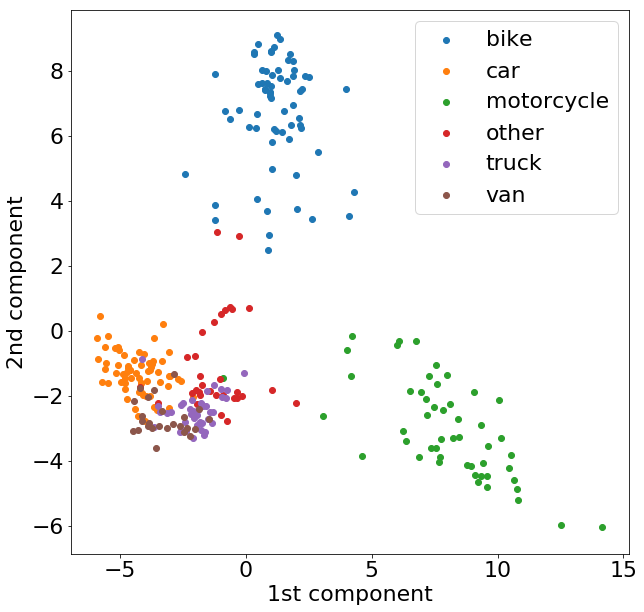

In [66]:
# Plot each kind of wine
plt.figure(figsize=(10,10))

for kind in range(0, len(data['class_name'])):
    # Wine samples of this type
    idx = (y == kind)

    # Plot their components
    plt.scatter(
        X_2d[idx, 0], X_2d[idx, 1],
        label=data['class_name'][kind]
    )

# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

## What can you say about the results?

The previous scatter plot shows that using the first 2 PCA components is enough to classify pictures representing bikes or motorcycles from the other classes.

Regarding the cars, trucks, van and others, the classification prediction using these 2 PCA components will lead to poor results.